<a href="https://colab.research.google.com/github/javmencia/RelativeBelief/blob/BiasCalculations/RegressionModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Bias Against

In [11]:
import numpy as np
import arviz as az

import pymc as pm
import pytensor.tensor as pt

import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy.special import gammaln
from scipy import stats
import time
import math

def normal_logp_np(x, mu, sigma):
    return -0.5 * ((x - mu) / sigma) ** 2 - np.log(sigma) - 0.5 * np.log(2 * np.pi)

In [2]:
n = 8  # Number of observations
p = 2  # Number of covariates

# Design matrix X
# X = np.random.normal(size=(n, p))
X = np.ones((n, p+1))
X[:int(n/2),1] = 0
X[0:-1:2,2] = 0

# Ground truth parameters for generating data
# beta0 = np.array([1, 2])
β_true = np.logspace(0, p, p+1, base=3) 
σ_true = 1
mu0 = np.dot(X, β_true)

# Generate response variable y
# y = np.dot(X, beta0) + np.random.normal(0, sigma0, n)
np.random.seed(135)
y = X@β_true + stats.norm(0,σ_true).rvs(n)
β_true,X,y # print("y", y)

(array([1., 3., 9.]),
 array([[1., 0., 0.],
        [1., 0., 1.],
        [1., 0., 0.],
        [1., 0., 1.],
        [1., 1., 0.],
        [1., 1., 1.],
        [1., 1., 0.],
        [1., 1., 1.]]),
 array([-0.26485598, 11.18428092,  1.35504683,  9.70205735,  3.46651589,
        13.43950814,  4.54291277, 13.0241124 ]))

In [37]:
# Prior parameters [with variable names translated to match changes above]
β_prior_μ = β_true
β_prior_σ = 1
σ_prior_μ = 1
σ_prior_σ = 1

# Posterior covariance for beta [can be precalculated]
# X_transpose = X.T
# Sigma_inv = np.eye(n) / sigma0**2
# Sigma_beta_inv = np.eye(p) / mu_prior_sigma**2
# cov_beta_post = np.linalg.inv(np.dot(X_transpose, np.dot(Sigma_inv, X)) + Sigma_beta_inv)
# print(cov_beta_post)
β_post_Φ = X.T@X + np.eye(p+1)*β_prior_σ**2
β_post_Σ = np.linalg.inv(β_post_Φ)
β_post_CholeskyLower = np.linalg.cholesky(β_post_Σ) # pt.linalg.cholesky # https://discourse.pymc.io/t/using-lkjcorr-together-with-mvnormal/13606/13?page=2

labels = ['intercept_'+str(β_true[0]), 'slope_'+str(β_true[1]), 'slope_'+str(β_true[2])]
with pm.Model(coords={'coefs': labels}) as model:

    # Prior parameters
    β = pm.Normal('β', mu=β_prior_μ, sigma=β_prior_σ, dims='coefs')
    σ = pm.TruncatedNormal("σ", mu=σ_prior_μ, sigma=σ_prior_σ, lower=0)
    # CONVERT to conjugate inverse gamma variance prior for analytical calculation
    # https://en.wikipedia.org/wiki/Bayesian_linear_regression#Conjugate_prior_distribution
    σ = 1 # or assume fixed and known σ    
    # [not using induced prior on mu articulation: yhats are functionals not parameters]
    # mu = pm.Deterministic("mu", pm.math.dot(X, beta))
    # prior_pd = pm.Deterministic("prior_pd", pm.logp(pm.MvNormal.dist(mu=mu_prior_mean, cov=(mu_prior_sigma**2)*np.eye(n), shape=(n,)), mu))    
    
    # Prior densities
    β_prior = pm.Normal.dist(mu=β_prior_μ, sigma=β_prior_σ, shape=(p+1,))
    σ_prior = pm.TruncatedNormal.dist(mu=σ_prior_μ, sigma=σ_prior_σ, lower=0)

    # Prior log density (ld) evaluations
    β_prior_ld = pm.Deterministic("β_prior_ld", pm.logp(β_prior,β).sum())
    σ_prior_ld = pm.Deterministic("σ_prior_ld", pm.logp(σ_prior,σ))
    θ_prior_ld = pm.Deterministic("θ_prior_ld", β_prior_ld+σ_prior_ld)
    
    # Likelihood
    y_hat = pm.Deterministic("y_hat", X@β) # pm.math.dot(X, beta))
    # y_ = pm.MvNormal('y_', mu=mu, cov= (sigma0**2)*np.eye(n), shape = n)
    y_ = pm.Normal('y_', mu=y_hat, sigma=σ)
    
    # Prior predictive density
    y_prior = pm.Normal.dist(mu=y_hat, sigma=σ, shape=(n,))
    
    # Prior log predictive density (lpd) # average estimates marginal likelihood
    y_prior_lpd = pm.Deterministic("y_prior_lpd", pm.logp(y_prior, y_).sum())
    # [wrong calculation: "plug-in" parameters must be integrated out to make prior]
    # likelihood_prior_pd = pm.Deterministic("likelihood_prior_pd", 
    # pm.logp(pm.MvNormal.dist(mu=mu0, cov=(sigma0**2)*np.eye(n), shape=n), y_).sum())
    
    # Analytical Posterior 
    β_post_μ = β_post_Σ @ (X.T@y_ + β_prior_μ/β_prior_σ**2)
    # EXTEND to σ²: https://en.wikipedia.org/wiki/Bayesian_linear_regression#Posterior_distribution]        
    # Posterior mean beta [incorrectly used y rather than y_]
    # mean_beta_post = np.dot(cov_beta_post, 
    # np.dot(X_transpose, np.dot(Sigma_inv, y)) + Sigma_beta_inv.dot(np.ones(p) * mu_prior_mean))
    # print(mean_beta_post)
    
    # Posterior predictive density    
    β_post = pm.MvNormal.dist(mu=β_post_μ, chol=β_post_CholeskyLower)
    # posterior_beta = pm.MvNormal('posterior_beta', mu=mean_beta_post, cov=cov_beta_post)

    # Posterior log density (ld) evaluations
    β_post_ld = pm.Deterministic("β_post_ld", pm.logp(β_post, β).sum())
    # posterior_pd = pm.Deterministic("posterior_pd", 
    # pm.logp(pm.MvNormal.dist(mu=pm.math.dot(X, posterior_beta), cov=(sigma0**2)*np.eye(n), shape=(n, )), mu).sum())    
    # [not using induced prior on mu articulation: yhats are functionals not parameters]
    
    # Analytical Log BR
    # logRB_prior_pd = pm.Deterministic("logRB_prior_pd", posterior_pd - prior_pd)
    logRB = pm.Deterministic("logRB", β_post_ld - β_post_ld)
    
    # Sampling
    idata = pm.sample(draws=5000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β, σ, y_]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 3 seconds.


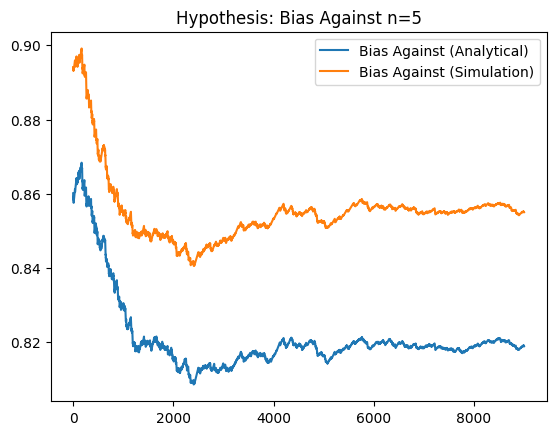

In [5]:
# Calculate the bias against the prior hypothesis
bias_against = idata.posterior["logRB_prior_pd"].values.ravel() <= 0
t = bias_against.shape[0]
burn = 1000
bias_against_mci = bias_against.cumsum() / np.arange(1, t+1)

# Extract posterior samples for simulation
beta_samples = idata.posterior['mu'][:, :, 0].values.ravel()
x_samples = idata.posterior['y_'].values  # Shape (chains, draws, n)

# Compute log likelihoods for all samples at once
marginal_likelihoods = normal_logp_np(x_samples[:, :, :, np.newaxis], beta_samples, 1).sum(axis=2)

# Average the likelihoods over the samples
log_marginal_likelihoods = np.log(np.exp(marginal_likelihoods).mean(axis=-1)).ravel()

# Compute biases
likelihood_prior_pd = idata.posterior['likelihood_prior_pd'].values.ravel()

bias_against_ml = (likelihood_prior_pd - log_marginal_likelihoods) <= 0

bias_against_ml_mci = bias_against_ml.cumsum() / np.arange(1, len(bias_against_ml) + 1)

plt.plot(bias_against_mci[burn:], label='Bias Against (Analytical)')
plt.plot(bias_against_ml_mci[burn:], label='Bias Against (Simulation)')
plt.title("Hypothesis: Bias Against n={}".format(n))
plt.legend()
plt.show()

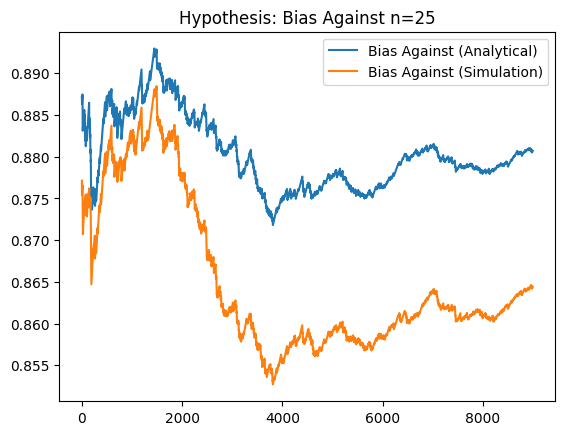

In [8]:
# Calculate the bias against the prior hypothesis
bias_against = idata.posterior["logRB_prior_pd"].values.ravel() <= 0
t = bias_against.shape[0]
burn = 1000
bias_against_mci = bias_against.cumsum() / np.arange(1, t+1)

# Extract posterior samples for simulation
beta_samples = idata.posterior['mu'][:, :, 0].values.ravel()[:1000]  # Use 1000 samples
x_samples = idata.posterior['y_'].values  # Shape (chains, draws, n)

# Compute log likelihoods for all samples at once
marginal_likelihoods = normal_logp_np(x_samples[:, :, :, np.newaxis], beta_samples, 1).sum(axis=2)

# Average the likelihoods over the samples
log_marginal_likelihoods = np.log(np.exp(marginal_likelihoods).mean(axis=-1)).ravel()

# Compute biases
likelihood_prior_pd = idata.posterior['likelihood_prior_pd'].values.ravel()

bias_against_ml = (likelihood_prior_pd - log_marginal_likelihoods) <= 0

bias_against_ml_mci = bias_against_ml.cumsum() / np.arange(1, len(bias_against_ml) + 1)

plt.plot(bias_against_mci[burn:], label='Bias Against (Analytical)')
plt.plot(bias_against_ml_mci[burn:], label='Bias Against (Simulation)')
plt.title("Hypothesis: Bias Against n={}".format(n))
plt.legend()
plt.show()

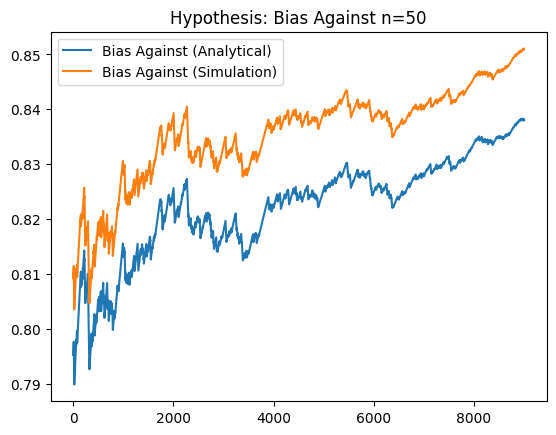

In [10]:
# Calculate the bias against the prior hypothesis
bias_against = idata.posterior["logRB_prior_pd"].values.ravel() <= 0
t = bias_against.shape[0]
burn = 1000
bias_against_mci = bias_against.cumsum() / np.arange(1, t+1)

# Extract posterior samples for simulation
beta_samples = idata.posterior['mu'][:, :, 0].values.ravel()[:1000]  # Use 1000 samples
x_samples = idata.posterior['y_'].values  # Shape (chains, draws, n)

# Compute log likelihoods for all samples at once
marginal_likelihoods = normal_logp_np(x_samples[:, :, :, np.newaxis], beta_samples, 1).sum(axis=2)

# Average the likelihoods over the samples
log_marginal_likelihoods = np.log(np.exp(marginal_likelihoods).mean(axis=-1)).ravel()

# Compute biases
likelihood_prior_pd = idata.posterior['likelihood_prior_pd'].values.ravel()

bias_against_ml = (likelihood_prior_pd - log_marginal_likelihoods) <= 0

bias_against_ml_mci = bias_against_ml.cumsum() / np.arange(1, len(bias_against_ml) + 1)

plt.plot(bias_against_mci[burn:], label='Bias Against (Analytical)')
plt.plot(bias_against_ml_mci[burn:], label='Bias Against (Simulation)')
plt.title("Hypothesis: Bias Against n={}".format(n))
plt.legend()
plt.show()

<ipython-input-14-f22dc6946506>:15: RuntimeWarning: divide by zero encountered in log
  log_marginal_likelihoods = np.log(np.exp(marginal_likelihoods).mean(axis=-1)).ravel()


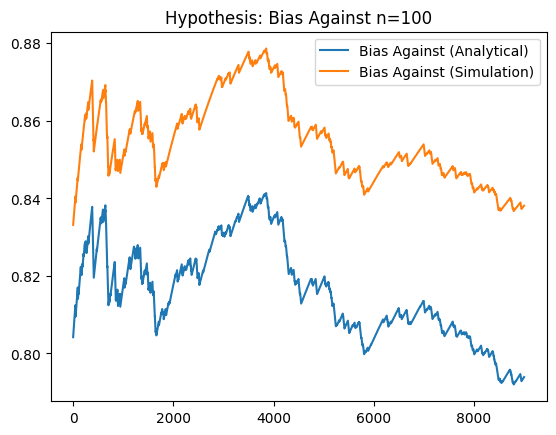

In [14]:
# Calculate the bias against the prior hypothesis
bias_against = idata.posterior["logRB_prior_pd"].values.ravel() <= 0
t = bias_against.shape[0]
burn = 1000
bias_against_mci = bias_against.cumsum() / np.arange(1, t+1)

# Extract posterior samples for simulation
beta_samples = idata.posterior['mu'][:, :, 0].values.ravel()[:1000]  # Use 1000 samples
x_samples = idata.posterior['y_'].values  # Shape (chains, draws, n)

# Compute log likelihoods for all samples at once
marginal_likelihoods = normal_logp_np(x_samples[:, :, :, np.newaxis], beta_samples, 1).sum(axis=2)

# Average the likelihoods over the samples
log_marginal_likelihoods = np.log(np.exp(marginal_likelihoods).mean(axis=-1)).ravel()

# Compute biases
likelihood_prior_pd = idata.posterior['likelihood_prior_pd'].values.ravel()

bias_against_ml = (likelihood_prior_pd - log_marginal_likelihoods) <= 0

bias_against_ml_mci = bias_against_ml.cumsum() / np.arange(1, len(bias_against_ml) + 1)

plt.plot(bias_against_mci[burn:], label='Bias Against (Analytical)')
plt.plot(bias_against_ml_mci[burn:], label='Bias Against (Simulation)')
plt.title("Hypothesis: Bias Against n={}".format(n))
plt.legend()
plt.show()

## Bias In Favor

#### Regular Upper Lower (Same delta for both)

In [17]:
import numpy as np
import pymc as pm
import arviz as az

# Define prior parameters
mu_prior_mean = 0
mu_prior_sigma = 1

sigma_prior_mu = 1
sigma_prior_sigma = 1

n = 20  # Number of observations
p = 2  # Number of covariates

# Design matrix X
X = np.random.normal(size=(n, p))

# Ground truth parameters for generating data
beta0 = np.array([1, 2])
delta = 0.05
sigma0 = 1
betal = beta0 - delta
print(betal)
betau = beta0 + delta
print(betau)

mu0 = np.dot(X, beta0)
mul = np.dot(X, betal)
muu = np.dot(X, betau)

# Generate response variable y
yl = mul + np.random.normal(0, sigma0, n)
yu = muu + np.random.normal(0, sigma0, n)

with pm.Model() as model:
    # Priors
    beta = pm.Normal('beta', mu=mu_prior_mean, sigma=mu_prior_sigma, shape=(p,))
    sigma = pm.TruncatedNormal("sigma", mu=sigma_prior_mu, sigma=sigma_prior_sigma, lower=0)

    # Likelihood
    mu = pm.Deterministic("mu", pm.math.dot(X, beta))
    y_l = pm.MvNormal('y_l', mu=mul, cov= (sigma0**2)*np.eye(n), shape = n)
    y_u = pm.MvNormal('y_u', mu=muu, cov= (sigma0**2)*np.eye(n), shape = n)

    # Prior log-probability
    prior_pd = pm.Deterministic("prior_pd", pm.logp(pm.MvNormal.dist(mu=mu_prior_mean, cov=(mu_prior_sigma**2)*np.eye(n), shape=(n,)), mu))

    # Posterior mean and covariance for beta
    X_transpose = X.T
    Sigma_inv = np.eye(n) / sigma0**2
    Sigma_beta_inv = np.eye(p) / mu_prior_sigma**2

    cov_beta_post = np.linalg.inv(np.dot(X_transpose, np.dot(Sigma_inv, X)) + Sigma_beta_inv)
    print(cov_beta_post)
    mean_beta_postl = np.dot(cov_beta_post, np.dot(X_transpose, np.dot(Sigma_inv, yl)) + Sigma_beta_inv.dot(np.ones(p) * mu_prior_mean))
    mean_beta_postu = np.dot(cov_beta_post, np.dot(X_transpose, np.dot(Sigma_inv, yu)) + Sigma_beta_inv.dot(np.ones(p) * mu_prior_mean))

    # Posterior log-probability
    posterior_betal = pm.MvNormal('posterior_betal', mu=mean_beta_postl, cov=cov_beta_post)
    posterior_betau = pm.MvNormal('posterior_betau', mu=mean_beta_postu, cov=cov_beta_post)

    posterior_pdl = pm.Deterministic("posterior_pdl", pm.logp(pm.MvNormal.dist(mu=pm.math.dot(X, posterior_betal), cov=(sigma0**2)*np.eye(n), shape=(n, )), mu0))
    posterior_pdu = pm.Deterministic("posterior_pdu", pm.logp(pm.MvNormal.dist(mu=pm.math.dot(X, posterior_betau), cov=(sigma0**2)*np.eye(n), shape=(n, )), mu0))

    # Log BR
    logBR_prior_pdl = pm.Deterministic("logBR_prior_pdl", posterior_pdl - prior_pd)
    logBR_prior_pdu = pm.Deterministic("logBR_prior_pdu", posterior_pdu - prior_pd)

    # Likelihood
    likelihood_prior_pdl = pm.Deterministic("likelihood_prior_pdl", pm.logp(pm.MvNormal.dist(mu=mu0, cov=(sigma**2)*np.eye(n), shape=n), y_l).sum())
    likelihood_prior_pdu = pm.Deterministic("likelihood_prior_pdu", pm.logp(pm.MvNormal.dist(mu=mu0, cov=(sigma**2)*np.eye(n), shape=n), y_u).sum())

    # Sampling
    idata = pm.sample(draws=5000, tune=1000)

[0.95 1.95]
[1.05 2.05]
[[ 0.06563761 -0.00915084]
 [-0.00915084  0.06279028]]


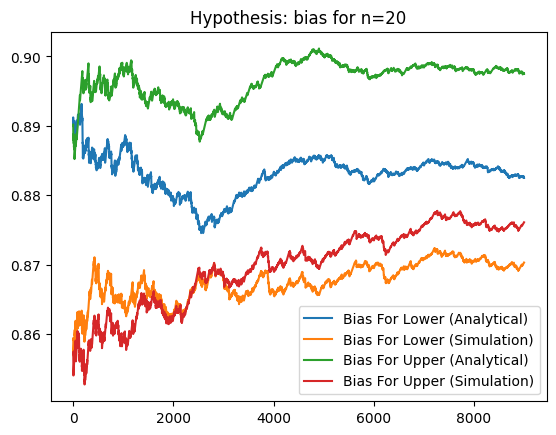

In [18]:
bias_forlower = idata.posterior['logBR_prior_pdl'].values.ravel() > 0
bias_forupper = idata.posterior['logBR_prior_pdu'].values.ravel() > 0
tl = bias_forlower.shape[0]
tu = bias_forupper.shape[0]
burn = 1000
bias_for_mcilower = bias_forlower.cumsum()/np.arange(1,tl+1)
bias_for_mciupper = bias_forupper.cumsum()/np.arange(1,tu+1)


use = 1000  # Number of samples to use

# Extract posterior samples
mu_samples = idata.posterior['mu'][:, :, 0].values.ravel()[:1000]  # Use 1000 samples
xl_samples = idata.posterior['y_l'].values  # Shape (chains, draws, n)
xu_samples = idata.posterior['y_u'].values  # Shape (chains, draws, n)


# Compute log likelihoods for all samples at once
marginal_likelihoods_lower = normal_logp_np(xl_samples[:, :, :, np.newaxis], mu_samples, 1).sum(axis=2)
marginal_likelihoods_upper = normal_logp_np(xu_samples[:, :, :, np.newaxis], mu_samples, 1).sum(axis=2)

# Average the likelihoods over the samples
log_marginal_likelihoods_lower = np.log(np.exp(marginal_likelihoods_lower).mean(axis=-1)).ravel()
log_marginal_likelihoods_upper = np.log(np.exp(marginal_likelihoods_upper).mean(axis=-1)).ravel()

# Compute biases
likelihood_prior_pd_lower = idata.posterior['likelihood_prior_pdl'].values.ravel()
likelihood_prior_pd_upper = idata.posterior['likelihood_prior_pdu'].values.ravel()

bias_for_ml_lower = (likelihood_prior_pd_lower - log_marginal_likelihoods_lower) >= 0
bias_for_ml_upper = (likelihood_prior_pd_upper - log_marginal_likelihoods_upper) >= 0

bias_for_ml_mci_lower = bias_for_ml_lower.cumsum() / np.arange(1, len(bias_for_ml_lower) + 1)
bias_for_ml_mci_upper = bias_for_ml_upper.cumsum() / np.arange(1, len(bias_for_ml_upper) + 1)

plt.plot(bias_for_mcilower[burn:], label='Bias For Lower (Analytical)')
plt.plot(bias_for_ml_mci_lower[burn:], label='Bias For Lower (Simulation)')
plt.plot(bias_for_mciupper[burn:], label='Bias For Upper (Analytical)')
plt.plot(bias_for_ml_mci_upper[burn:], label='Bias For Upper (Simulation)')
plt.title("Hypothesis: bias for n={}".format(n))
plt.legend()


#### Delta values around the circle:

In [ ]:
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import time

# Define prior parameters
mu_prior_mean = 0
mu_prior_sigma = 1

sigma_prior_mu = 1
sigma_prior_sigma = 1

n = 20  # Number of observations
p = 2  # Number of covariates

# Design matrix X
X = np.random.normal(size=(n, p))

# Ground truth parameters for generating data
beta0 = np.array([1, 2])
mu0 = np.dot(X, beta0)
delta = 0.05
sigma0 = 1

# Generate points on the circle
num_points = 40  # Number of points on the circle
theta = np.linspace(0, 2 * np.pi, num_points)
circle_points = np.column_stack((beta0[0] + delta * np.cos(theta), beta0[1] + delta * np.sin(theta)))



# Vectorized response variable generation
muls = np.dot(X, circle_points.T).T  # Shape: (num_points, n)
yls = muls + np.random.normal(0, sigma0, (num_points, n))  # Shape: (num_points, n)

posterior_pds = []
logBR_prior_pds = []
likelihood_prior_pds = []

start_time = time.time()

with pm.Model() as model:
    # Priors
    beta = pm.Normal('beta', mu=mu_prior_mean, sigma=mu_prior_sigma, shape=(p,))
    sigma = pm.TruncatedNormal("sigma", mu=sigma_prior_mu, sigma=sigma_prior_sigma, lower=0)

    mu = pm.Deterministic("mu", pm.math.dot(X, beta))

    X_transpose = X.T
    Sigma_inv = np.eye(n) / sigma0**2
    Sigma_beta_inv = np.eye(p) / mu_prior_sigma**2

    cov_beta_post = np.linalg.inv(np.dot(X_transpose, np.dot(Sigma_inv, X)) + Sigma_beta_inv)

    # Iterate over each point on the circle
    for i, betal in enumerate(circle_points):
        # Calculate mu for each point on the circle

        # Likelihood
        y_l = pm.MvNormal(f'y_l_{i}', mu=muls[i], cov=(sigma0**2) * np.eye(n), shape=n)
        # Posterior mean and covariance for beta
        mean_beta_post = np.dot(cov_beta_post, np.dot(X_transpose, np.dot(Sigma_inv, yls[i])) + Sigma_beta_inv.dot(np.ones(p) * mu_prior_mean))

        # Posterior log-probability
        posterior_betal = pm.MvNormal(f'posterior_betal_{i}', mu=mean_beta_post, cov=cov_beta_post)
        posterior_pdl = pm.Deterministic(f'posterior_pdl_{i}', pm.logp(pm.MvNormal.dist(mu=pm.math.dot(X, posterior_betal), cov=(sigma0**2) * np.eye(n), shape=(n,)), mu0))
        posterior_pds.append(posterior_pdl)

        # Log BR
        logBR_prior_pdl = pm.Deterministic(f'logBR_prior_pdl_{i}', posterior_pdl - pm.logp(pm.MvNormal.dist(mu=mu_prior_mean, cov=(mu_prior_sigma**2) * np.eye(n), shape=(n,)), pm.math.dot(X, beta)))
        logBR_prior_pds.append(logBR_prior_pdl)

        # Likelihood
        likelihood_prior_pdl = pm.Deterministic(f'likelihood_prior_pdl_{i}', pm.logp(pm.MvNormal.dist(mu=mu0, cov=(sigma**2) * np.eye(n), shape=n), y_l).sum())
        likelihood_prior_pds.append(likelihood_prior_pdl)

    # Sampling
    idata = pm.sample(draws=5000, tune=1000)

end_time = time.time()

# Calculate elapsed time
elapsed_time = end_time - start_time

print(f"Cell execution time: {elapsed_time:.2f} seconds")


Cell execution time: 6134.59 seconds


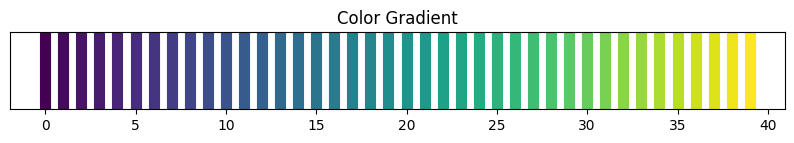

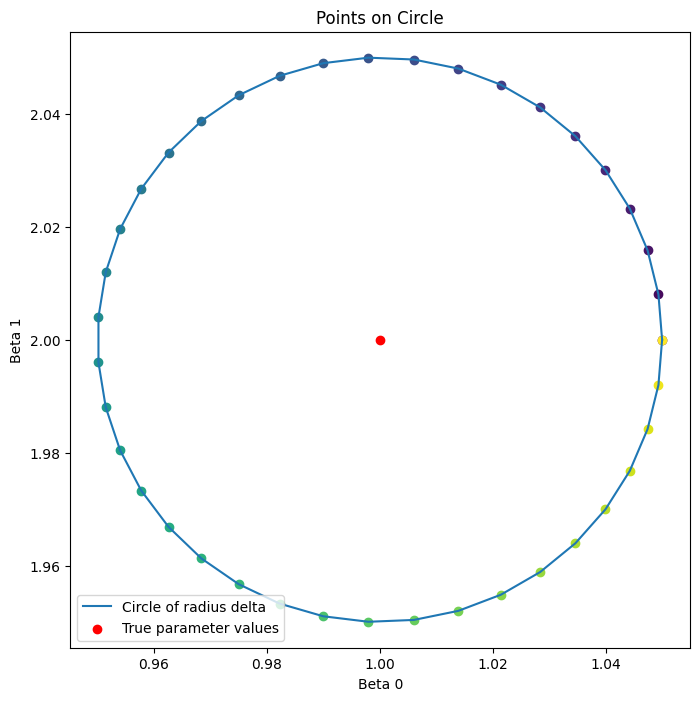

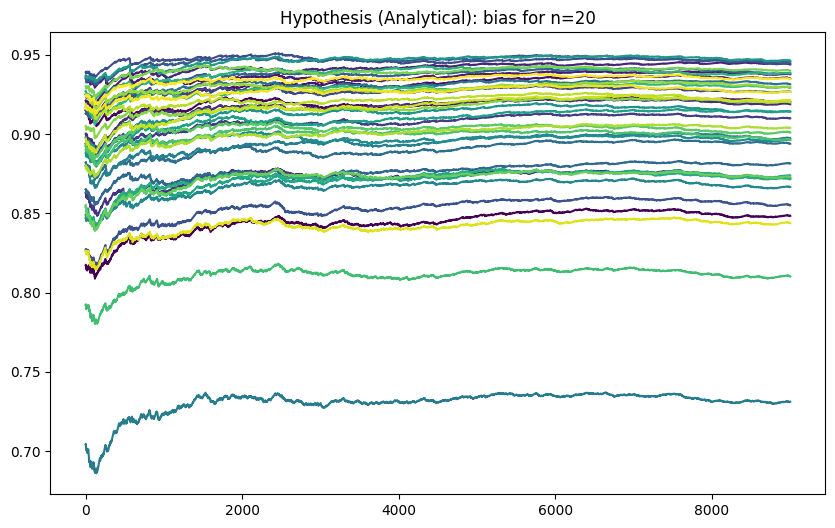

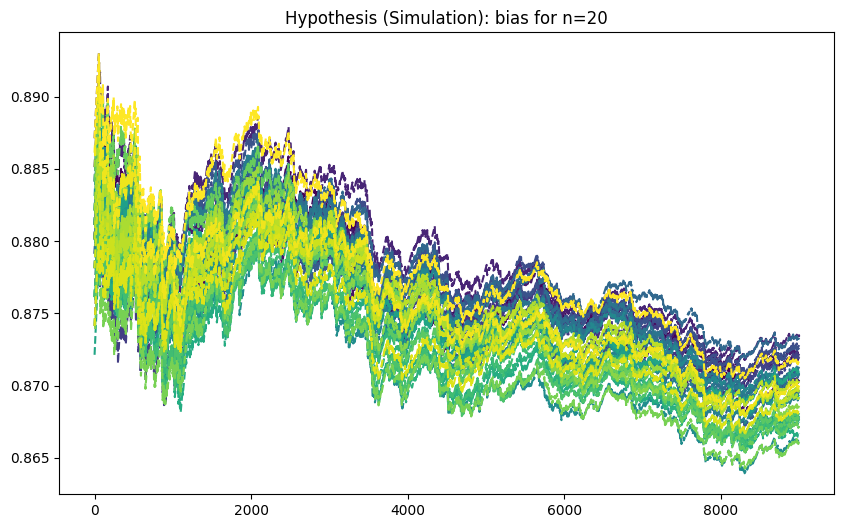

In [ ]:
from matplotlib import cm

# Convert lists to numpy arrays
posterior_pds = np.array(posterior_pds)
logBR_prior_pds = np.array(logBR_prior_pds)
likelihood_prior_pds = np.array(likelihood_prior_pds)

# Compute biases for all points on the circle
bias_for = []
bias_for_ml = []
burn = 1000
for idx in range(num_points):
    logBR_prior_pd_values = idata.posterior[f'logBR_prior_pdl_{idx}'].values.ravel()
    likelihood_prior_pd_values = idata.posterior[f'likelihood_prior_pdl_{idx}'].values.ravel()

    bias_for_values = logBR_prior_pd_values > 0
    bias_for_mci = bias_for_values.cumsum() / np.arange(1, len(bias_for_values) + 1)

    mu_samples = idata.posterior['mu'][:, :, 0].values.ravel()[:1000]
    y_samples = idata.posterior[f'y_l_{idx}'].values
    marginal_likelihoods = normal_logp_np(y_samples[:, :, :, np.newaxis], mu_samples, 1).sum(axis=2)
    log_marginal_likelihoods = np.log(np.exp(marginal_likelihoods).mean(axis=-1)).ravel()

    bias_for_ml_values = (likelihood_prior_pd_values - log_marginal_likelihoods) >= 0
    bias_for_ml_mci = bias_for_ml_values.cumsum() / np.arange(1, len(bias_for_ml_values) + 1)

    bias_for.append(bias_for_mci)
    bias_for_ml.append(bias_for_ml_mci)

# Generate colors from a colormap
colors = cm.viridis(np.linspace(0, 1, num_points))

# Plotting the color gradient
plt.figure(figsize=(10, 1))
for idx, color in enumerate(colors):
    plt.plot([idx, idx], [0, 1], color=color, linewidth=8)
plt.title("Color Gradient")
plt.yticks([])
plt.show()

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# True parameter values
beta0 = np.array([1, 2])
delta = 0.05  # Radius of the circle

# Generate points on the circle
theta = np.linspace(0, 2 * np.pi, num_points)
x = beta0[0] + delta * np.cos(theta)
y = beta0[1] + delta * np.sin(theta)

# Generate colors from a colormap
colors = cm.viridis(np.linspace(0, 1, num_points))

# Plotting the circle and the true parameter values
plt.figure(figsize=(8, 8))
plt.plot(x, y, label='Circle of radius delta')
plt.scatter(beta0[0], beta0[1], color='red', label='True parameter values')

# Plotting the points with corresponding colors
circle_points = np.column_stack((x, y))
for idx in range(num_points):
    plt.scatter(circle_points[idx, 0], circle_points[idx, 1], color=colors[idx])

plt.xlabel('Beta 0')
plt.ylabel('Beta 1')
plt.legend(loc=3)
plt.axis('equal')
plt.title('Points on Circle')
plt.show()

# Plotting
plt.figure(figsize=(10, 6))
for idx in range(num_points):
    plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colors[idx])
    #plt.plot(bias_for_ml[idx][burn:], label=f'Bias For (Simulation) Point {idx}', linestyle='--', color=colors[idx])

plt.title("Hypothesis (Analytical): bias for n={}".format(n))
plt.show()

plt.figure(figsize=(10, 6))
for idx in range(num_points):
    #plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colors[idx])
    plt.plot(bias_for_ml[idx][burn:], label=f'Bias For (Simulation) Point {idx}', linestyle='--', color=colors[idx])

plt.title("Hypothesis (Simulation): bias for n={}".format(n))
plt.show()

#### Rhombus

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# True parameter values
beta0 = np.array([1, 2])
delta = 0.05  # Half-diagonal length of the rhombus

# Generate points on the rhombus
num_points_per_side = 25  # Number of points on each side of the rhombus

# Define the four vertices of the rhombus
vertices = np.array([
    [beta0[0] + delta, beta0[1]],  # Right vertex
    [beta0[0], beta0[1] + delta],  # Top vertex
    [beta0[0] - delta, beta0[1]],  # Left vertex
    [beta0[0], beta0[1] - delta]   # Bottom vertex
])

# Generate points along each side of the rhombus
points = []
for i in range(4):
    start = vertices[i]
    end = vertices[(i + 1) % 4]
    side_points = np.linspace(start, end, num_points_per_side)
    points.append(side_points)

# Concatenate all points
rhombus_points = np.vstack(points)




In [5]:
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import time

start_time = time.time()
# Define prior parameters
mu_prior_mean = 0
mu_prior_sigma = 1

sigma_prior_mu = 1
sigma_prior_sigma = 1

n = 20  # Number of observations
p = 2  # Number of covariates

# Design matrix X
X = np.random.normal(size=(n, p))

# Ground truth parameters for generating data
beta0 = np.array([1, 2])
mu0 = np.dot(X, beta0)
delta = 0.05
sigma0 = 1

# Generate points on the rhombus
num_points_per_side = 10  # Number of points on each side of the rhombus

# Define the four vertices of the rhombus
vertices = np.array([
    [beta0[0] + delta, beta0[1]],  # Right vertex
    [beta0[0], beta0[1] + delta],  # Top vertex
    [beta0[0] - delta, beta0[1]],  # Left vertex
    [beta0[0], beta0[1] - delta]   # Bottom vertex
])

# Generate points along each side of the rhombus
points = []
for i in range(4):
    start = vertices[i]
    end = vertices[(i + 1) % 4]
    side_points = np.linspace(start, end, num_points_per_side)
    points.append(side_points)

# Concatenate all points
rhombus_points = np.vstack(points)

posterior_pds = []
logBR_prior_pds = []
likelihood_prior_pds = []


with pm.Model() as model:
    # Priors
    beta = pm.Normal('beta', mu=mu_prior_mean, sigma=mu_prior_sigma, shape=(p,))
    sigma = pm.TruncatedNormal("sigma", mu=sigma_prior_mu, sigma=sigma_prior_sigma, lower=0)

    mu = pm.Deterministic("mu", pm.math.dot(X, beta))

    X_transpose = X.T
    Sigma_inv = np.eye(n) / sigma0**2
    Sigma_beta_inv = np.eye(p) / mu_prior_sigma**2

    # Iterate over each point on the circle
    for i, betal in enumerate(rhombus_points):
        # Calculate mu for each point on the circle
        mul = np.dot(X, betal)

        # Generate response variable y for each point on the circle
        yl = mul + np.random.normal(0, sigma0, n)
        # Likelihood
        y_l = pm.MvNormal(f'y_l_{i}', mu=mul, cov=(sigma0**2) * np.eye(n), shape=n)
        # Posterior mean and covariance for beta
        cov_beta_post = np.linalg.inv(np.dot(X_transpose, np.dot(Sigma_inv, X)) + Sigma_beta_inv)
        mean_beta_post = np.dot(cov_beta_post, np.dot(X_transpose, np.dot(Sigma_inv, yl)) + Sigma_beta_inv.dot(np.ones(p) * mu_prior_mean))

        # Posterior log-probability
        posterior_betal = pm.MvNormal(f'posterior_betal_{i}', mu=mean_beta_post, cov=cov_beta_post)
        posterior_pdl = pm.Deterministic(f'posterior_pdl_{i}', pm.logp(pm.MvNormal.dist(mu=pm.math.dot(X, posterior_betal), cov=(sigma0**2) * np.eye(n), shape=(n,)), mu0))
        posterior_pds.append(posterior_pdl)

        # Log BR
        logBR_prior_pdl = pm.Deterministic(f'logBR_prior_pdl_{i}', posterior_pdl - pm.logp(pm.MvNormal.dist(mu=mu_prior_mean, cov=(mu_prior_sigma**2) * np.eye(n), shape=(n,)), pm.math.dot(X, beta)))
        logBR_prior_pds.append(logBR_prior_pdl)

        # Likelihood
        likelihood_prior_pdl = pm.Deterministic(f'likelihood_prior_pdl_{i}', pm.logp(pm.MvNormal.dist(mu=mu0, cov=(sigma**2) * np.eye(n), shape=n), y_l).sum())
        likelihood_prior_pds.append(likelihood_prior_pdl)

    # Sampling
    idata = pm.sample(draws=5000, tune=1000)

end_time = time.time()

# Calculate elapsed time
elapsed_time = end_time - start_time

print(f"Cell execution time: {elapsed_time:.2f} seconds")




Cell execution time: 5222.58 seconds


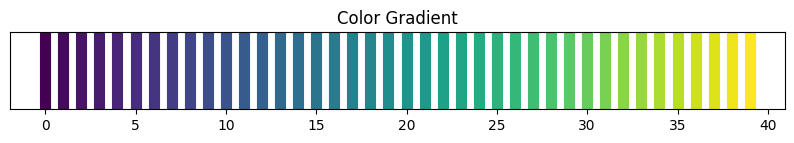

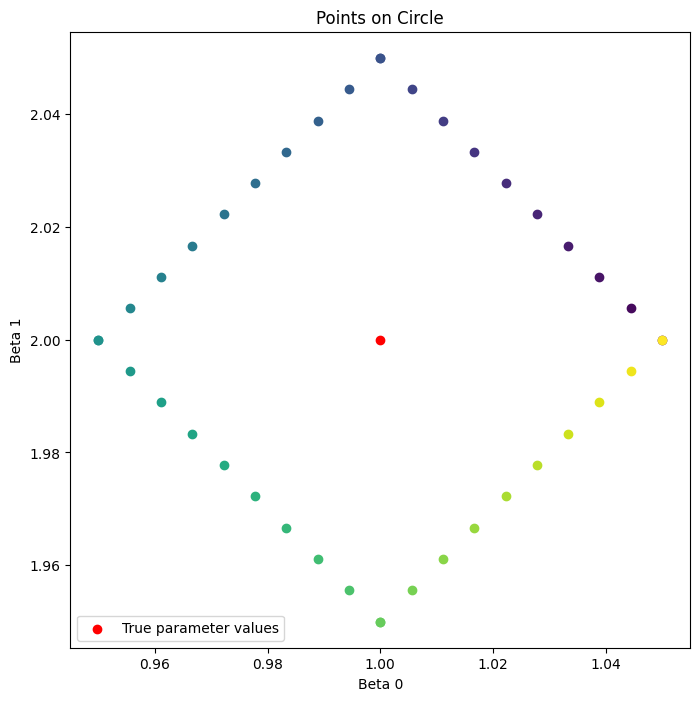

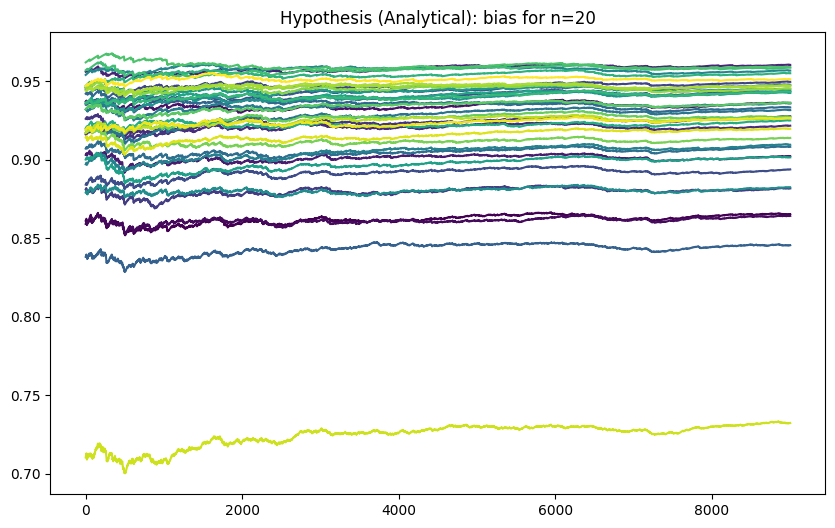

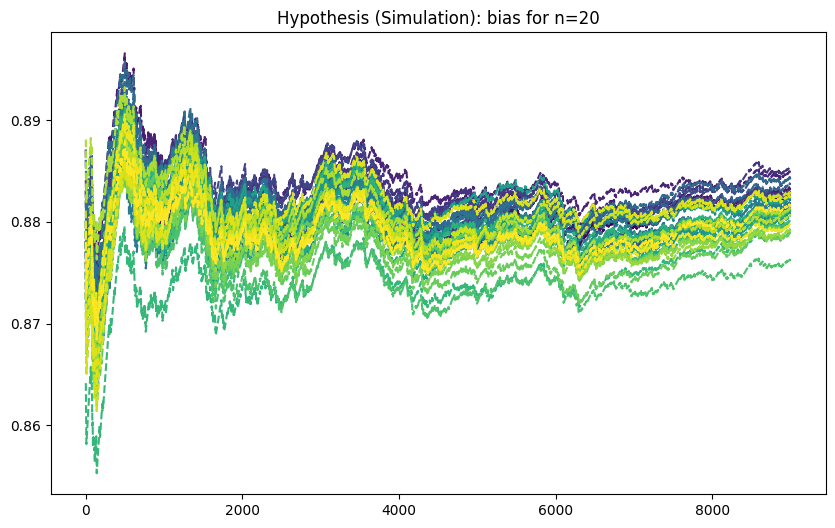

In [9]:
from matplotlib import cm
num_points = len(rhombus_points)
def normal_logp_np(x, mu, sigma):
    return -0.5 * ((x - mu) / sigma) ** 2 - np.log(sigma) - 0.5 * np.log(2 * np.pi)
# Convert lists to numpy arrays
posterior_pds = np.array(posterior_pds)
logBR_prior_pds = np.array(logBR_prior_pds)
likelihood_prior_pds = np.array(likelihood_prior_pds)

# Compute biases for all points on the circle
bias_for = []
bias_for_ml = []
burn = 1000
for idx in range(num_points):
    logBR_prior_pd_values = idata.posterior[f'logBR_prior_pdl_{idx}'].values.ravel()
    likelihood_prior_pd_values = idata.posterior[f'likelihood_prior_pdl_{idx}'].values.ravel()

    bias_for_values = logBR_prior_pd_values > 0
    bias_for_mci = bias_for_values.cumsum() / np.arange(1, len(bias_for_values) + 1)

    mu_samples = idata.posterior['mu'][:, :, 0].values.ravel()[:1000]
    y_samples = idata.posterior[f'y_l_{idx}'].values
    marginal_likelihoods = normal_logp_np(y_samples[:, :, :, np.newaxis], mu_samples, 1).sum(axis=2)
    log_marginal_likelihoods = np.log(np.exp(marginal_likelihoods).mean(axis=-1)).ravel()

    bias_for_ml_values = (likelihood_prior_pd_values - log_marginal_likelihoods) >= 0
    bias_for_ml_mci = bias_for_ml_values.cumsum() / np.arange(1, len(bias_for_ml_values) + 1)

    bias_for.append(bias_for_mci)
    bias_for_ml.append(bias_for_ml_mci)

# Generate colors from a colormap
colors = cm.viridis(np.linspace(0, 1, num_points))

# Plotting the color gradient
plt.figure(figsize=(10, 1))
for idx, color in enumerate(colors):
    plt.plot([idx, idx], [0, 1], color=color, linewidth=8)
plt.title("Color Gradient")
plt.yticks([])
plt.show()

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# True parameter values
beta0 = np.array([1, 2])
delta = 0.05  # Radius of the circle



# Generate colors from a colormap
colors = cm.viridis(np.linspace(0, 1, num_points))

# Plotting the circle and the true parameter values
plt.figure(figsize=(8, 8))
plt.scatter(beta0[0], beta0[1], color='red', label='True parameter values')


for idx in range(num_points):
    plt.scatter(rhombus_points[idx, 0], rhombus_points[idx, 1], color=colors[idx])

plt.xlabel('Beta 0')
plt.ylabel('Beta 1')
plt.legend(loc=3)
plt.axis('equal')
plt.title('Points on Circle')
plt.show()

# Plotting
plt.figure(figsize=(10, 6))
for idx in range(num_points):
    plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colors[idx])
    #plt.plot(bias_for_ml[idx][burn:], label=f'Bias For (Simulation) Point {idx}', linestyle='--', color=colors[idx])

plt.title("Hypothesis (Analytical): bias for n={}".format(n))
plt.show()

plt.figure(figsize=(10, 6))
for idx in range(num_points):
    #plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colors[idx])
    plt.plot(bias_for_ml[idx][burn:], label=f'Bias For (Simulation) Point {idx}', linestyle='--', color=colors[idx])

plt.title("Hypothesis (Simulation): bias for n={}".format(n))
plt.show()

Inward Rhombus

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import binom

# Function to calculate Bezier curve points
def bezier_curve(control_points, num_points=100):
    n = len(control_points) - 1
    curve = np.zeros((num_points, 2))
    t = np.linspace(0, 1, num_points)
    for i in range(n + 1):
        curve += np.outer(binom(n, i) * (t ** i) * ((1 - t) ** (n - i)), control_points[i])
    return curve

# True parameter values
beta0 = np.array([1, 2])
delta = 0.05  # Half-diagonal length of the rhombus

# Define the four vertices of the rhombus
vertices = np.array([
    [beta0[0] + delta, beta0[1]],  # Right vertex
    [beta0[0], beta0[1] + delta],  # Top vertex
    [beta0[0] - delta, beta0[1]],  # Left vertex
    [beta0[0], beta0[1] - delta]   # Bottom vertex
])

# Define control points for inward-curving sides
control_points = []
control_points.append([vertices[0], beta0, vertices[1]])  # Right to Top
control_points.append([vertices[1], beta0, vertices[2]])  # Top to Left
control_points.append([vertices[2], beta0, vertices[3]])  # Left to Bottom
control_points.append([vertices[3], beta0, vertices[0]])  # Bottom to Right

# Generate points on the inward-curving rhombus
num_points_per_curve = 8
curved_points = []
for cp in control_points:
    curve = bezier_curve(cp, num_points_per_curve)
    curved_points.append(curve)

# Concatenate all points
curved_rhombus_points = np.vstack(curved_points)


In [19]:
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import time

# Define prior parameters
mu_prior_mean = 0
mu_prior_sigma = 1

sigma_prior_mu = 1
sigma_prior_sigma = 1

n = 20  # Number of observations
p = 2  # Number of covariates

# Design matrix X
X = np.random.normal(size=(n, p))

# Ground truth parameters for generating data
beta0 = np.array([1, 2])
mu0 = np.dot(X, beta0)
delta = 0.05
sigma0 = 1

num_points = len(curved_rhombus_points)

# Vectorized response variable generation
muls = np.dot(X, curved_rhombus_points.T).T  # Shape: (25, n)
yls = muls + np.random.normal(0, sigma0, (num_points, n))  # Shape: (25, n)

posterior_pds = []
logBR_prior_pds = []
likelihood_prior_pds = []

start_time = time.time()

with pm.Model() as model:
    # Priors
    beta = pm.Normal('beta', mu=mu_prior_mean, sigma=mu_prior_sigma, shape=(p,))
    sigma = pm.TruncatedNormal("sigma", mu=sigma_prior_mu, sigma=sigma_prior_sigma, lower=0)

    mu = pm.Deterministic("mu", pm.math.dot(X, beta))

    X_transpose = X.T
    Sigma_inv = np.eye(n) / sigma0**2
    Sigma_beta_inv = np.eye(p) / mu_prior_sigma**2

    cov_beta_post = np.linalg.inv(np.dot(X_transpose, np.dot(Sigma_inv, X)) + Sigma_beta_inv)

    # Iterate over each point on the circle
    for i, betal in enumerate(curved_rhombus_points):
        # Calculate mu for each point on the circle

        # Likelihood
        y_l = pm.MvNormal(f'y_l_{i}', mu=muls[i], cov=(sigma0**2) * np.eye(n), shape=n)
        # Posterior mean and covariance for beta
        mean_beta_post = np.dot(cov_beta_post, np.dot(X_transpose, np.dot(Sigma_inv, yls[i])) + Sigma_beta_inv.dot(np.ones(p) * mu_prior_mean))

        # Posterior log-probability
        posterior_betal = pm.MvNormal(f'posterior_betal_{i}', mu=mean_beta_post, cov=cov_beta_post)
        posterior_pdl = pm.Deterministic(f'posterior_pdl_{i}', pm.logp(pm.MvNormal.dist(mu=pm.math.dot(X, posterior_betal), cov=(sigma0**2) * np.eye(n), shape=(n,)), mu0))
        posterior_pds.append(posterior_pdl)

        # Log BR
        logBR_prior_pdl = pm.Deterministic(f'logBR_prior_pdl_{i}', posterior_pdl - pm.logp(pm.MvNormal.dist(mu=mu_prior_mean, cov=(mu_prior_sigma**2) * np.eye(n), shape=(n,)), pm.math.dot(X, beta)))
        logBR_prior_pds.append(logBR_prior_pdl)

        # Likelihood
        likelihood_prior_pdl = pm.Deterministic(f'likelihood_prior_pdl_{i}', pm.logp(pm.MvNormal.dist(mu=mu0, cov=(sigma**2) * np.eye(n), shape=n), y_l).sum())
        likelihood_prior_pds.append(likelihood_prior_pdl)

    # Sampling
    idata = pm.sample(draws=5000, tune=1000)

end_time = time.time()

# Calculate elapsed time
elapsed_time = end_time - start_time

print(f"Cell execution time: {elapsed_time:.2f} seconds")


Cell execution time: 2800.04 seconds


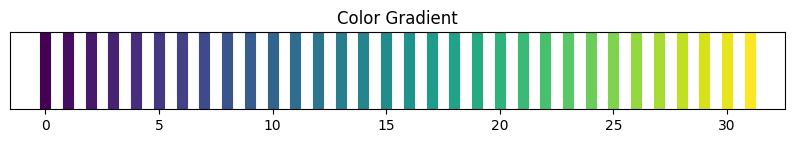

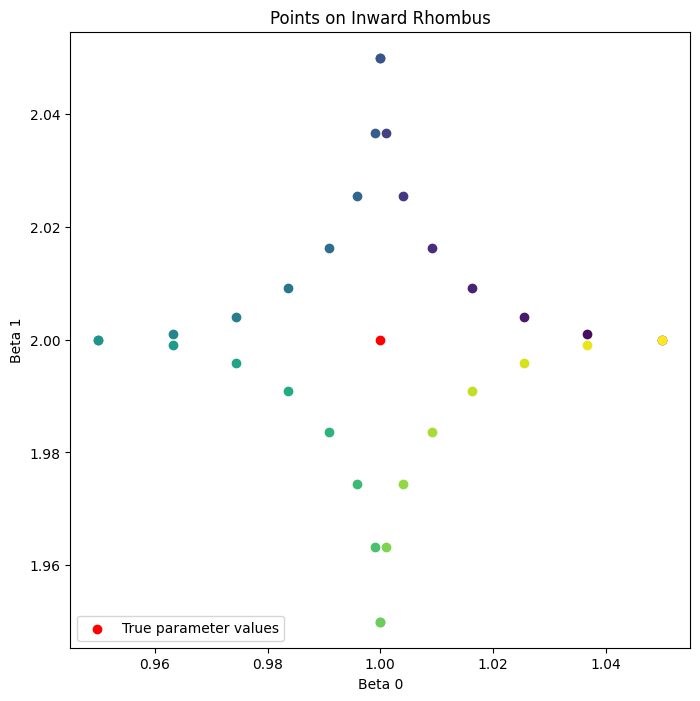

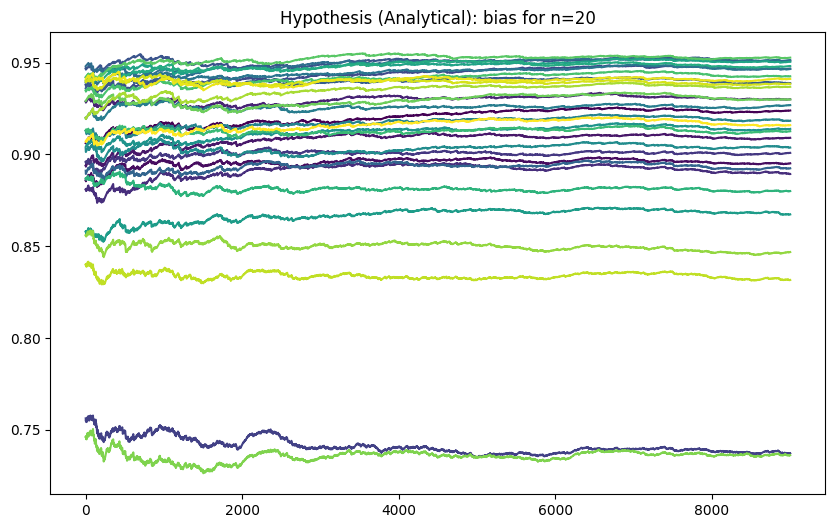

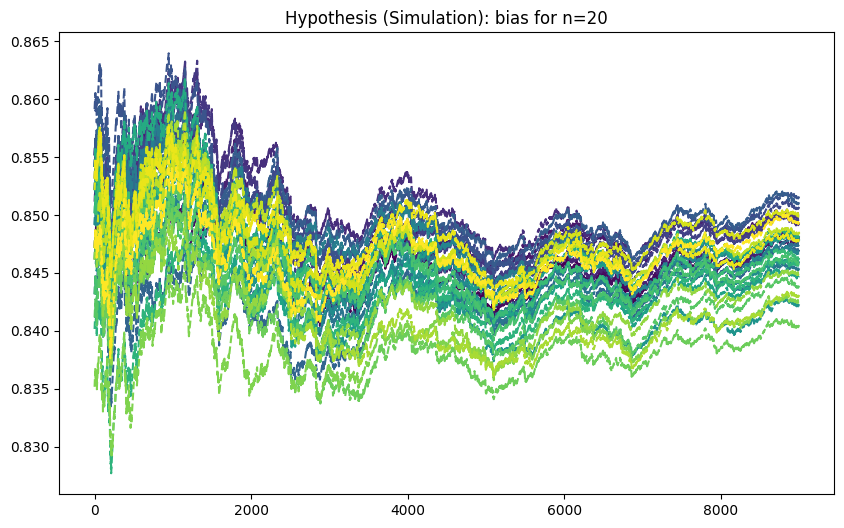

In [15]:
from matplotlib import cm
def normal_logp_np(x, mu, sigma):
    return -0.5 * ((x - mu) / sigma) ** 2 - np.log(sigma) - 0.5 * np.log(2 * np.pi)
# Convert lists to numpy arrays
posterior_pds = np.array(posterior_pds)
logBR_prior_pds = np.array(logBR_prior_pds)
likelihood_prior_pds = np.array(likelihood_prior_pds)

# Compute biases for all points on the circle
bias_for = []
bias_for_ml = []
burn = 1000
for idx in range(num_points):
    logBR_prior_pd_values = idata.posterior[f'logBR_prior_pdl_{idx}'].values.ravel()
    likelihood_prior_pd_values = idata.posterior[f'likelihood_prior_pdl_{idx}'].values.ravel()

    bias_for_values = logBR_prior_pd_values > 0
    bias_for_mci = bias_for_values.cumsum() / np.arange(1, len(bias_for_values) + 1)

    mu_samples = idata.posterior['mu'][:, :, 0].values.ravel()[:1000]
    y_samples = idata.posterior[f'y_l_{idx}'].values
    marginal_likelihoods = normal_logp_np(y_samples[:, :, :, np.newaxis], mu_samples, 1).sum(axis=2)
    log_marginal_likelihoods = np.log(np.exp(marginal_likelihoods).mean(axis=-1)).ravel()

    bias_for_ml_values = (likelihood_prior_pd_values - log_marginal_likelihoods) >= 0
    bias_for_ml_mci = bias_for_ml_values.cumsum() / np.arange(1, len(bias_for_ml_values) + 1)

    bias_for.append(bias_for_mci)
    bias_for_ml.append(bias_for_ml_mci)

# Generate colors from a colormap
colors = cm.viridis(np.linspace(0, 1, num_points))

# Plotting the color gradient
plt.figure(figsize=(10, 1))
for idx, color in enumerate(colors):
    plt.plot([idx, idx], [0, 1], color=color, linewidth=8)
plt.title("Color Gradient")
plt.yticks([])
plt.show()


# Generate colors from a colormap
colors = cm.viridis(np.linspace(0, 1, num_points))

# Plotting the circle and the true parameter values
plt.figure(figsize=(8, 8))
plt.scatter(beta0[0], beta0[1], color='red', label='True parameter values')


for idx in range(num_points):
    plt.scatter(curved_rhombus_points[idx, 0], curved_rhombus_points[idx, 1], color=colors[idx])

plt.xlabel('Beta 0')
plt.ylabel('Beta 1')
plt.legend(loc=3)
plt.axis('equal')
plt.title('Points on Inward Rhombus')
plt.show()


# Plotting
plt.figure(figsize=(10, 6))
for idx in range(num_points):
    plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colors[idx])
    #plt.plot(bias_for_ml[idx][burn:], label=f'Bias For (Simulation) Point {idx}', linestyle='--', color=colors[idx])

plt.title("Hypothesis (Analytical): bias for n={}".format(n))
plt.show()

plt.figure(figsize=(10, 6))
for idx in range(num_points):
    #plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colors[idx])
    plt.plot(bias_for_ml[idx][burn:], label=f'Bias For (Simulation) Point {idx}', linestyle='--', color=colors[idx])

plt.title("Hypothesis (Simulation): bias for n={}".format(n))
plt.show()

Vectorising a bit

In [21]:
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import time

# Define prior parameters
mu_prior_mean = 0
mu_prior_sigma = 1

sigma_prior_mu = 1
sigma_prior_sigma = 1

n = 20  # Number of observations
p = 2  # Number of covariates

# Design matrix X
X = np.random.normal(size=(n, p))

# Ground truth parameters for generating data
beta0 = np.array([1, 2])
mu0 = np.dot(X, beta0)
delta = 0.05
sigma0 = 1

num_points = len(curved_rhombus_points)

# Vectorized response variable generation
muls = np.dot(X, curved_rhombus_points.T).T  # Shape: (25, n)
yls = muls + np.random.normal(0, sigma0, (num_points, n))  # Shape: (25, n)


posterior_pds = []
logBR_prior_pds = []
likelihood_prior_pds = []

start_time = time.time()

with pm.Model() as model:
    # Priors
    beta = pm.Normal('beta', mu=mu_prior_mean, sigma=mu_prior_sigma, shape=(p,))
    sigma = pm.TruncatedNormal("sigma", mu=sigma_prior_mu, sigma=sigma_prior_sigma, lower=0)

    mu = pm.Deterministic("mu", pm.math.dot(X, beta))

    X_transpose = X.T
    Sigma_inv = np.eye(n) / sigma0**2
    Sigma_beta_inv = np.eye(p) / mu_prior_sigma**2

    cov_beta_post = np.linalg.inv(np.dot(X_transpose, np.dot(Sigma_inv, X)) + Sigma_beta_inv)
    # Vectorize mean_beta_post calculation
    yls_stack = np.stack(yls)  # Shape: (num_points, n)
    Sigma_inv_dot_yls = np.dot(Sigma_inv, yls_stack.T).T  # Shape: (num_points, n)
    mean_beta_posts = (np.dot(cov_beta_post, np.dot(X_transpose, Sigma_inv_dot_yls.T) + Sigma_beta_inv.dot(np.ones(p) * mu_prior_mean)[:, np.newaxis])).T

    print(mean_beta_posts)
    y_ls = pm.MvNormal('y_l', mu=muls, cov=(sigma0**2) * np.eye(n), shape=(num_points, n))
    posterior_betals = pm.MvNormal('posterior_betal', mu=mean_beta_posts, cov=cov_beta_post, shape = (num_points, p))
    # Iterate over each point on the circle
    for i, betal in enumerate(curved_rhombus_points):
        # Calculate mu for each point on the circle
        y_l = pm.Deterministic(f'y_l_{i}', y_ls[i])
        # Likelihood
        #y_l = pm.MvNormal(f'y_l_{i}', mu=muls[i], cov=(sigma0**2) * np.eye(n), shape=n)
        # Posterior mean and covariance for beta

        # Posterior log-probability
        posterior_pdl = pm.Deterministic(f'posterior_pdl_{i}', pm.logp(pm.MvNormal.dist(mu=pm.math.dot(X, posterior_betals[i]), cov=(sigma0**2) * np.eye(n), shape=(n,)), mu0))
        #posterior_pds.append(posterior_pdl)

        # Log BR
        logBR_prior_pdl = pm.Deterministic(f'logBR_prior_pdl_{i}', posterior_pdl - pm.logp(pm.MvNormal.dist(mu=mu_prior_mean, cov=(mu_prior_sigma**2) * np.eye(n), shape=(n,)), pm.math.dot(X, beta)))
        #logBR_prior_pds.append(logBR_prior_pdl)

        # Likelihood
        likelihood_prior_pdl = pm.Deterministic(f'likelihood_prior_pdl_{i}', pm.logp(pm.MvNormal.dist(mu=mu0, cov=(sigma**2) * np.eye(n), shape=n), y_l).sum())
        #likelihood_prior_pds.append(likelihood_prior_pdl)

    # Sampling
    idata = pm.sample(draws=5000, tune=1000)

end_time = time.time()

# Calculate elapsed time
elapsed_time = end_time - start_time

print(f"Cell execution time: {elapsed_time:.2f} seconds")


[[0.75931715 1.91511982]
 [0.96828751 1.72327895]
 [0.7952531  2.05317036]
 [0.96221731 1.94419816]
 [1.08480785 1.84235991]
 [0.03364449 1.80740699]
 [1.31425886 2.20829235]
 [0.47052881 2.03765993]
 [0.72962566 2.00012807]
 [0.6741275  1.88918045]
 [0.74688605 1.9414825 ]
 [1.01168478 1.81203206]
 [0.43458609 1.77460037]
 [0.47270734 1.96614265]
 [1.39047985 2.1474089 ]
 [0.68528763 1.99370512]
 [1.33671401 2.07789432]
 [1.22511875 2.17076955]
 [0.60231697 2.20062317]
 [0.58803989 1.74408376]
 [1.08151453 1.73143142]
 [0.91208451 1.70434216]
 [1.01618652 1.79353537]
 [1.32815849 1.83064118]
 [0.97341806 1.9612841 ]
 [0.68099019 1.94791184]
 [0.94210935 1.88005733]
 [0.58213442 1.72176424]
 [0.66321006 1.85742462]
 [1.07458823 2.11414179]
 [1.01818854 1.92316644]
 [0.73779598 2.09726722]]


Cell execution time: 1229.79 seconds


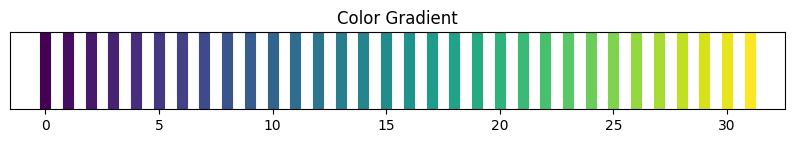

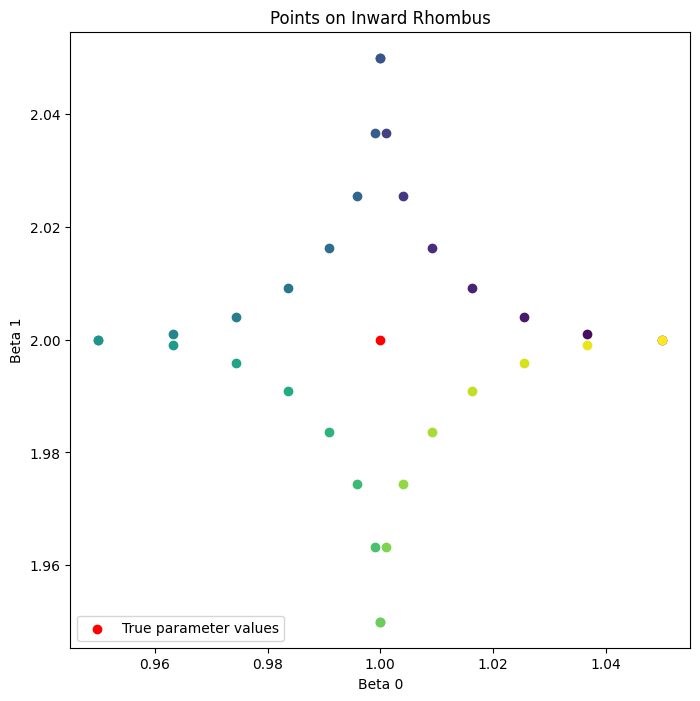

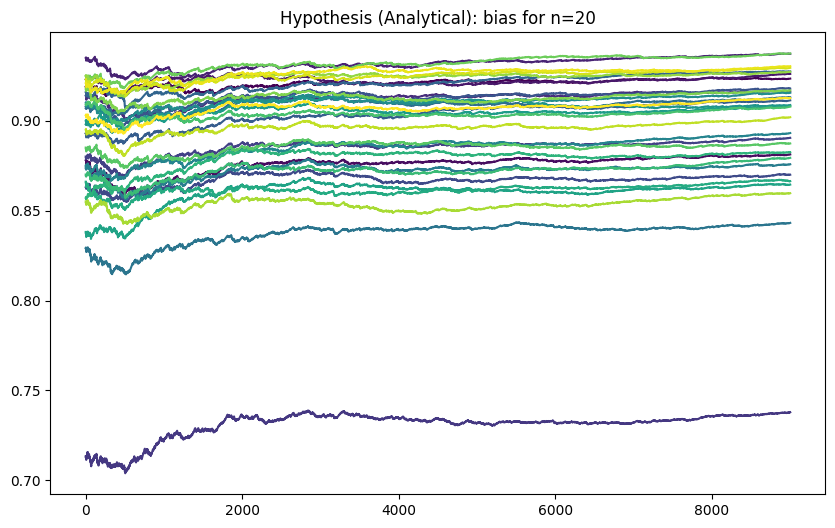

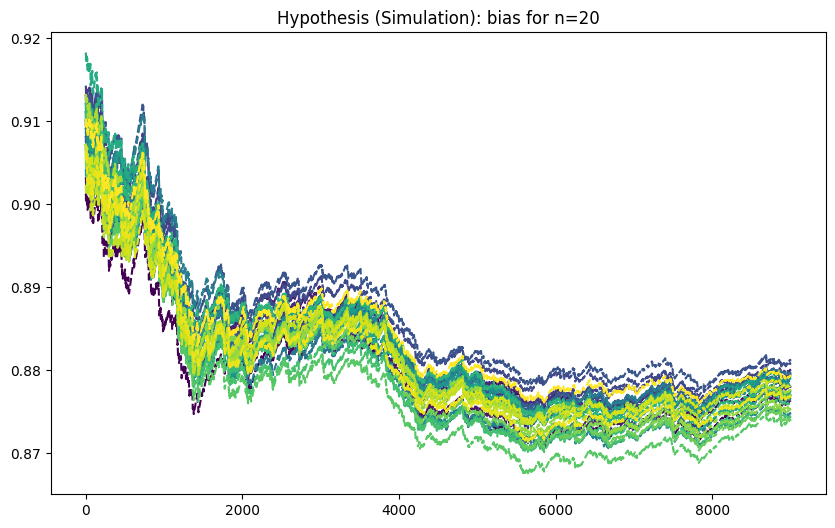

In [22]:
from matplotlib import cm
def normal_logp_np(x, mu, sigma):
    return -0.5 * ((x - mu) / sigma) ** 2 - np.log(sigma) - 0.5 * np.log(2 * np.pi)
# Convert lists to numpy arrays
#posterior_pds = np.array(posterior_pds)
#logBR_prior_pds = np.array(logBR_prior_pds)
#likelihood_prior_pds = np.array(likelihood_prior_pds)

# Compute biases for all points on the circle
bias_for = []
bias_for_ml = []
burn = 1000
for idx in range(num_points):
    logBR_prior_pd_values = idata.posterior[f'logBR_prior_pdl_{idx}'].values.ravel()
    likelihood_prior_pd_values = idata.posterior[f'likelihood_prior_pdl_{idx}'].values.ravel()

    bias_for_values = logBR_prior_pd_values > 0
    bias_for_mci = bias_for_values.cumsum() / np.arange(1, len(bias_for_values) + 1)

    mu_samples = idata.posterior['mu'][:, :, 0].values.ravel()[:1000]
    y_samples = idata.posterior[f'y_l_{idx}'].values
    marginal_likelihoods = normal_logp_np(y_samples[:, :, :, np.newaxis], mu_samples, 1).sum(axis=2)
    log_marginal_likelihoods = np.log(np.exp(marginal_likelihoods).mean(axis=-1)).ravel()

    bias_for_ml_values = (likelihood_prior_pd_values - log_marginal_likelihoods) >= 0
    bias_for_ml_mci = bias_for_ml_values.cumsum() / np.arange(1, len(bias_for_ml_values) + 1)

    bias_for.append(bias_for_mci)
    bias_for_ml.append(bias_for_ml_mci)

# Generate colors from a colormap
colors = cm.viridis(np.linspace(0, 1, num_points))

# Plotting the color gradient
plt.figure(figsize=(10, 1))
for idx, color in enumerate(colors):
    plt.plot([idx, idx], [0, 1], color=color, linewidth=8)
plt.title("Color Gradient")
plt.yticks([])
plt.show()


# Generate colors from a colormap
colors = cm.viridis(np.linspace(0, 1, num_points))

# Plotting the circle and the true parameter values
plt.figure(figsize=(8, 8))
plt.scatter(beta0[0], beta0[1], color='red', label='True parameter values')


for idx in range(num_points):
    plt.scatter(curved_rhombus_points[idx, 0], curved_rhombus_points[idx, 1], color=colors[idx])

plt.xlabel('Beta 0')
plt.ylabel('Beta 1')
plt.legend(loc=3)
plt.axis('equal')
plt.title('Points on Inward Rhombus')
plt.show()


# Plotting
plt.figure(figsize=(10, 6))
for idx in range(num_points):
    plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colors[idx])
    #plt.plot(bias_for_ml[idx][burn:], label=f'Bias For (Simulation) Point {idx}', linestyle='--', color=colors[idx])

plt.title("Hypothesis (Analytical): bias for n={}".format(n))
plt.show()

plt.figure(figsize=(10, 6))
for idx in range(num_points):
    #plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colors[idx])
    plt.plot(bias_for_ml[idx][burn:], label=f'Bias For (Simulation) Point {idx}', linestyle='--', color=colors[idx])

plt.title("Hypothesis (Simulation): bias for n={}".format(n))
plt.show()

Using a larger n

In [6]:
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import time

# Define prior parameters
mu_prior_mean = 0
mu_prior_sigma = 1

sigma_prior_mu = 1
sigma_prior_sigma = 1

n = 50  # Number of observations
p = 2  # Number of covariates

# Design matrix X
X = np.random.normal(size=(n, p))

# Ground truth parameters for generating data
beta0 = np.array([1, 2])
mu0 = np.dot(X, beta0)
delta = 0.05
sigma0 = 1

num_points = len(curved_rhombus_points)

# Vectorized response variable generation
muls = np.dot(X, curved_rhombus_points.T).T  # Shape: (25, n)
yls = muls + np.random.normal(0, sigma0, (num_points, n))  # Shape: (25, n)


posterior_pds = []
logBR_prior_pds = []
likelihood_prior_pds = []

start_time = time.time()

with pm.Model() as model:
    # Priors
    beta = pm.Normal('beta', mu=mu_prior_mean, sigma=mu_prior_sigma, shape=(p,))
    sigma = pm.TruncatedNormal("sigma", mu=sigma_prior_mu, sigma=sigma_prior_sigma, lower=0)

    mu = pm.Deterministic("mu", pm.math.dot(X, beta))

    X_transpose = X.T
    Sigma_inv = np.eye(n) / sigma0**2
    Sigma_beta_inv = np.eye(p) / mu_prior_sigma**2

    cov_beta_post = np.linalg.inv(np.dot(X_transpose, np.dot(Sigma_inv, X)) + Sigma_beta_inv)
    # Vectorize mean_beta_post calculation
    yls_stack = np.stack(yls)  # Shape: (num_points, n)
    Sigma_inv_dot_yls = np.dot(Sigma_inv, yls_stack.T).T  # Shape: (num_points, n)
    mean_beta_posts = (np.dot(cov_beta_post, np.dot(X_transpose, Sigma_inv_dot_yls.T) + Sigma_beta_inv.dot(np.ones(p) * mu_prior_mean)[:, np.newaxis])).T

    print(mean_beta_posts)
    y_ls = pm.MvNormal('y_l', mu=muls, cov=(sigma0**2) * np.eye(n), shape=(num_points, n))
    posterior_betals = pm.MvNormal('posterior_betal', mu=mean_beta_posts, cov=cov_beta_post, shape = (num_points, p))
    # Iterate over each point on the circle
    for i, betal in enumerate(curved_rhombus_points):
        # Calculate mu for each point on the circle
        y_l = pm.Deterministic(f'y_l_{i}', y_ls[i])
        # Likelihood
        #y_l = pm.MvNormal(f'y_l_{i}', mu=muls[i], cov=(sigma0**2) * np.eye(n), shape=n)
        # Posterior mean and covariance for beta

        # Posterior log-probability
        posterior_pdl = pm.Deterministic(f'posterior_pdl_{i}', pm.logp(pm.MvNormal.dist(mu=pm.math.dot(X, posterior_betals[i]), cov=(sigma0**2) * np.eye(n), shape=(n,)), mu0))
        #posterior_pds.append(posterior_pdl)

        # Log BR
        logBR_prior_pdl = pm.Deterministic(f'logBR_prior_pdl_{i}', posterior_pdl - pm.logp(pm.MvNormal.dist(mu=mu_prior_mean, cov=(mu_prior_sigma**2) * np.eye(n), shape=(n,)), pm.math.dot(X, beta)))
        #logBR_prior_pds.append(logBR_prior_pdl)

        # Likelihood
        likelihood_prior_pdl = pm.Deterministic(f'likelihood_prior_pdl_{i}', pm.logp(pm.MvNormal.dist(mu=mu0, cov=(sigma**2) * np.eye(n), shape=n), y_l).sum())
        #likelihood_prior_pds.append(likelihood_prior_pdl)

    # Sampling
    idata = pm.sample(draws=5000, tune=1000)

end_time = time.time()

# Calculate elapsed time
elapsed_time = end_time - start_time

print(f"Cell execution time: {elapsed_time:.2f} seconds")


[[0.88209774 2.18802248]
 [0.86957494 2.02332685]
 [1.08064287 1.84154724]
 [0.99355293 1.9501602 ]
 [1.08974768 1.91015355]
 [0.79502868 2.23894249]
 [1.13102932 1.86870947]
 [0.93191834 1.85579156]
 [1.17314175 1.75495404]
 [0.86346459 2.14216042]
 [0.95321985 2.13365604]
 [0.91264341 1.81554113]
 [1.06381033 1.74205583]
 [0.82421156 2.05366854]
 [1.04024796 2.03383973]
 [1.09286534 1.9563201 ]
 [0.94471028 1.92828129]
 [1.32372848 1.88509056]
 [1.16034135 1.89465179]
 [1.16898754 1.80242916]
 [0.95366676 2.07443094]
 [1.00465074 2.15451577]
 [1.01590724 1.69832155]
 [1.02445027 1.8777897 ]
 [0.79037233 1.76083383]
 [0.9639829  2.03641883]
 [1.11622275 1.74244175]
 [0.82101559 1.94084331]
 [0.82953042 2.09148212]
 [1.07781172 1.86333153]
 [1.03975501 2.17392932]
 [1.06886714 1.9739064 ]]


Cell execution time: 1158.04 seconds


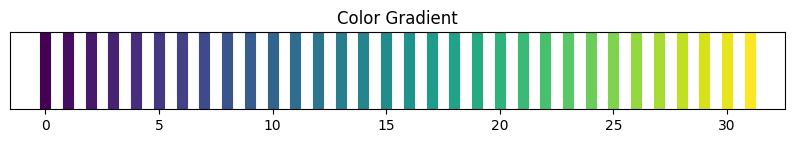

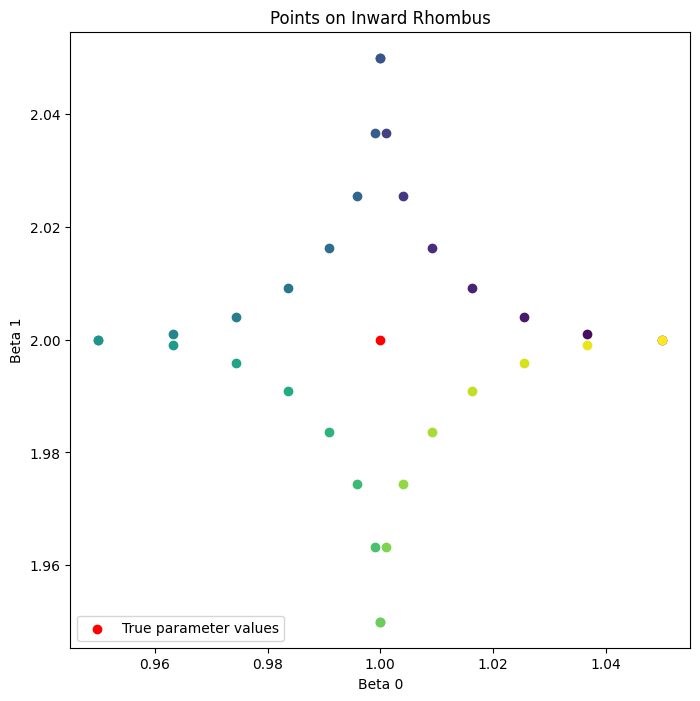

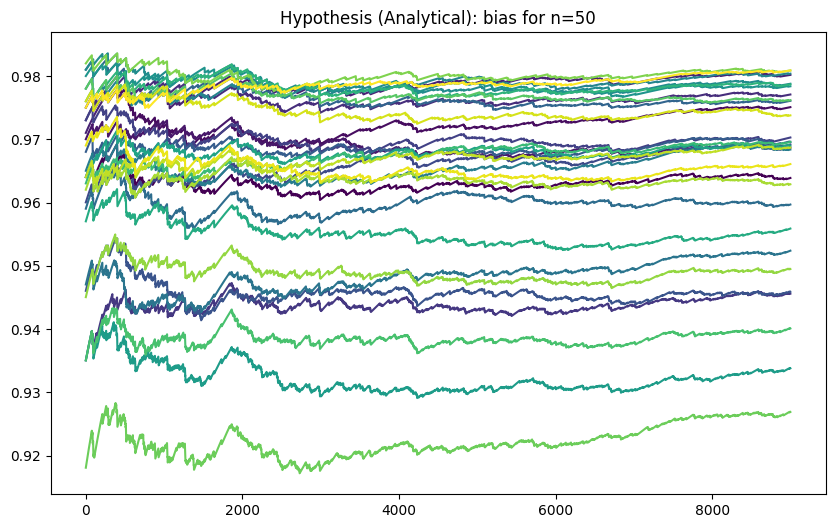

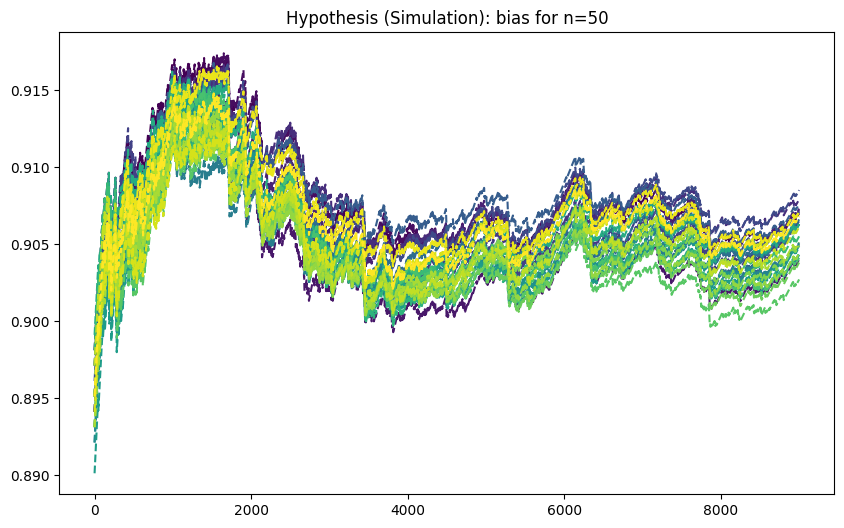

In [8]:
from matplotlib import cm
def normal_logp_np(x, mu, sigma):
    return -0.5 * ((x - mu) / sigma) ** 2 - np.log(sigma) - 0.5 * np.log(2 * np.pi)
# Convert lists to numpy arrays
#posterior_pds = np.array(posterior_pds)
#logBR_prior_pds = np.array(logBR_prior_pds)
#likelihood_prior_pds = np.array(likelihood_prior_pds)

# Compute biases for all points on the circle
bias_for = []
bias_for_ml = []
burn = 1000
for idx in range(num_points):
    logBR_prior_pd_values = idata.posterior[f'logBR_prior_pdl_{idx}'].values.ravel()
    likelihood_prior_pd_values = idata.posterior[f'likelihood_prior_pdl_{idx}'].values.ravel()

    bias_for_values = logBR_prior_pd_values > 0
    bias_for_mci = bias_for_values.cumsum() / np.arange(1, len(bias_for_values) + 1)

    mu_samples = idata.posterior['mu'][:, :, 0].values.ravel()[:1000]
    y_samples = idata.posterior[f'y_l_{idx}'].values
    marginal_likelihoods = normal_logp_np(y_samples[:, :, :, np.newaxis], mu_samples, 1).sum(axis=2)
    log_marginal_likelihoods = np.log(np.exp(marginal_likelihoods).mean(axis=-1)).ravel()

    bias_for_ml_values = (likelihood_prior_pd_values - log_marginal_likelihoods) >= 0
    bias_for_ml_mci = bias_for_ml_values.cumsum() / np.arange(1, len(bias_for_ml_values) + 1)

    bias_for.append(bias_for_mci)
    bias_for_ml.append(bias_for_ml_mci)

# Generate colors from a colormap
colors = cm.viridis(np.linspace(0, 1, num_points))

# Plotting the color gradient
plt.figure(figsize=(10, 1))
for idx, color in enumerate(colors):
    plt.plot([idx, idx], [0, 1], color=color, linewidth=8)
plt.title("Color Gradient")
plt.yticks([])
plt.show()


# Generate colors from a colormap
colors = cm.viridis(np.linspace(0, 1, num_points))

# Plotting the circle and the true parameter values
plt.figure(figsize=(8, 8))
plt.scatter(beta0[0], beta0[1], color='red', label='True parameter values')


for idx in range(num_points):
    plt.scatter(curved_rhombus_points[idx, 0], curved_rhombus_points[idx, 1], color=colors[idx])

plt.xlabel('Beta 0')
plt.ylabel('Beta 1')
plt.legend(loc=3)
plt.axis('equal')
plt.title('Points on Inward Rhombus')
plt.show()


# Plotting
plt.figure(figsize=(10, 6))
for idx in range(num_points):
    plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colors[idx])
    #plt.plot(bias_for_ml[idx][burn:], label=f'Bias For (Simulation) Point {idx}', linestyle='--', color=colors[idx])

plt.title("Hypothesis (Analytical): bias for n={}".format(n))
plt.show()

plt.figure(figsize=(10, 6))
for idx in range(num_points):
    #plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colors[idx])
    plt.plot(bias_for_ml[idx][burn:], label=f'Bias For (Simulation) Point {idx}', linestyle='--', color=colors[idx])

plt.title("Hypothesis (Simulation): bias for n={}".format(n))
plt.show()